# Introduction


In this assignment, you will practice building and training Convolutional Neural Networks with Pytorch to solve computer vision tasks.  This assignment includes two sections, each involving different tasks:

(1) Image Classification. Predict image-level category labels on two historically notable image datasets: **CIFAR-10** and **MNIST**.

(2) Image Segmentation. Predict pixel-wise classification (semantic segmentation) on synthetic input images formed by superimposing MNIST images on top of CIFAR images.

You will design your own models in each section and build the entire training/testing pipeline with PyTorch. 
PyTorch provides optimized implementations of the building blocks and additional utilities, both of which will be necessary for experiments on real datasets. It is highly recommended to read the official [documentation](https://pytorch.org/docs/stable/index.html) and [examples](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html) before starting your implementation. There are some APIs that you'll find useful:
[Layers](http://pytorch.org/docs/stable/nn.html),
[Activations](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity),
[Loss functions](http://pytorch.org/docs/stable/nn.html#loss-functions),
[Optimizers](http://pytorch.org/docs/stable/optim.html)

It is highly recommended to use Google Colab and run the notebook on a GPU node. Check https://colab.research.google.com/ and look for tutorials online. To use a GPU go to Runtime -> Change runtime type and select GPU. 


# (2) Image Segmentation
The task consists of performing pixel-wise classification on a synthetic dataset
of 32x32 RGB images. Each image was generated by placing a MNIST sample (a grayscale
image of a digit between 0 and 9) on top of a CIFAR-10 sample (a RGB image drawn from
one of 10 possible classes). Each image has an accompanying target tensor of size 32x32,
where in each pixel location (i,j) it contains the ground-truth label of the MNIST digit
(ranging from 0 to 9) or of the CIFAR-10 image (ranging from 10 to 19), depending on whether
the (i,j) pixel in the original image belongs to the superposed MNIST image or not. The
metric of interest here is pixel-wise accuracy, which is the fraction of pixels in each image
for which your model predicted the correct class (out of a total of 20 classes, as described 
above).

Note that there are many ways to frame the above task. For example, your CNN can directly
output a 20x32x32 tensor for each input image, representing a distribution over the possible
20 classes for each of the 32x32 pixels. However, note that the problem has a lot of additional
structure: for example, each 32x32 target tensor only has two distinct numbers in it, the label
of the MNIST digit and the label of the CIFAR-10 background image -- accounting for such
structure will make training faster and likely improve your model's final performance. Your
model should be able to achieve around 70% accuracy on the test set when trained for 100 epochs.

To finish this section step by step, you need to:

* Prepare data by building a dataset and data loader. (already provided below)

* Implement training code (6 points) & testing code (6 points), including saving and loading of models.

* Construct a model (12 points) and choose an optimizer (3 points).

* Describe what you did, any additional features you implemented, and/or any graphs you made in training and evaluating your network. Report final test accuracy @100 epochs in a writeup: hw3.pdf (3 points)

In [3]:
import numpy as np
import os
import math
import torch
import random
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from torch.utils.data import random_split
import torchvision
import matplotlib.pyplot as plt
import torchvision.transforms as T
from utils import SegDataset


## Data Preparation:

Setup a Dataset for training and testing.

Datasets load single training examples one a time, so we practically wrap each Dataset in a DataLoader, which loads a data batch in parallel.

In [4]:
seg_train = SegDataset('./data', train=True, transform=None)
loader_train = DataLoader(seg_train, batch_size=64, shuffle=True)
seg_test = SegDataset('./data', train=False, transform=None)
loader_test = DataLoader(seg_test, batch_size=64, shuffle=False)


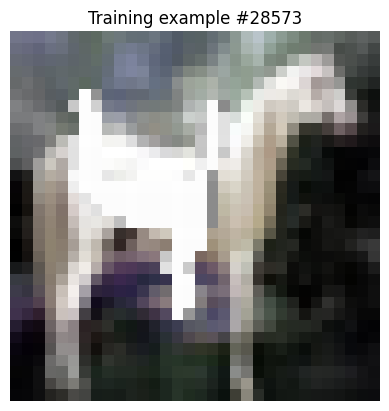

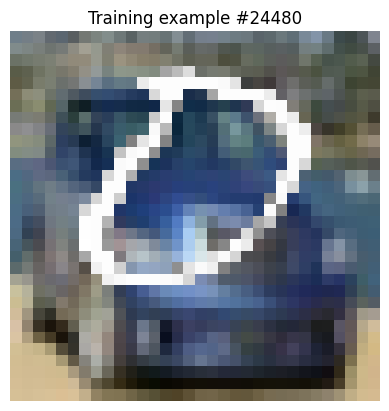

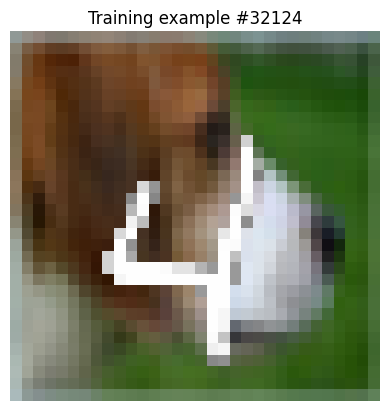

In [5]:
def visualize_samples(dataset, num_samples):
    for _ in range(num_samples):
        random_seg_img = random.randint(0, len(dataset))
        x, y = dataset[random_seg_img]
        plt.imshow(x.permute(1, 2, 0))
        plt.title(f"Training example #{random_seg_img}")
        plt.axis('off')
        plt.show()
visualize_samples(seg_train, 3)

## Design/choose your own model structure (12 points) and optimizer (3 points).
You might want to adjust following configurations for better performance:

(1) Network architecture:
- You can borrow some ideas from existing convnets design, e.g., [ResNet](https://arxiv.org/abs/1512.03385) where
the input from the previous layer is added to the output, or [UNet](https://arxiv.org/pdf/1505.04597.pdf) where you can stack intermediate features from previous layers. 
- Note: Do not **directly copy** an existing network design.

(2) Architecture hyperparameters:
- Filter size, number of filters, and number of layers (depth). Make careful choices to tradeoff computational efficiency and accuracy.
- Pooling vs. Strided Convolution
- Batch normalization
- Choice of non-linear activation

(3) Choice of optimizer (e.g., SGD, Adam, Adagrad, RMSprop) and associated hyperparameters (e.g., learning rate, momentum).


In [6]:
#Basic model, feel free to customize the layout to fit your model design.

##########################################################################
# TODO: YOUR CODE HERE
# (1) Complete the model
##########################################################################

class myNet(nn.Module):
    def __init__(self):
        super(myNet, self).__init__()
        
        # batch normalization = bad, https://arxiv.org/abs/1903.07291
        self.pool = nn.MaxPool2d(kernel_size = 2)
        self.dropout = nn.Dropout(0.5)

        # Encoder layers
        self.encodeLayer1 = nn.Conv2d(3, 64, 3, padding = 1) # 32 x 32 x 64
        self.encodeLayer2 = nn.Conv2d(64, 64, 3, padding=1)
        # After max pooling, output will be 16 x 16 x 64

        self.encodeLayer3 = nn.Conv2d(64, 128, 3, padding = 1) # 16 x 16 x 128
        self.encodeLayer4 = nn.Conv2d(128, 128, 3, padding=1)
        # After max pooling, output will be 8 x 8 x 128

        self.encodeLayer5 = nn.Conv2d(128, 256, 3, padding = 1) # 32 x 32 x 32
        self.encodeLayer6 = nn.Conv2d(256, 256, 3, padding=1)
        # After max pooling, output will be 4 x 4 x 256

        self.encodeLayer7 = nn.Conv2d(256, 512, 3, padding = 1) # 4 x 4 x 512
        self.encodeLayer8 = nn.Conv2d(512, 512, 3, padding=1)
        # After max pooling, output will be 2 x 2 x 512
        
        self.encodeLayer9 = nn.Conv2d(512, 1024, 3, padding = 1) # 32 x 32 x 32
        self.encodeLayer10 = nn.Conv2d(1024, 1024, 3, padding=1)

        # Decoder layers
        self.decodeUpConv1 = nn.ConvTranspose2d(1024, 512, 2, 2)
        self.decodeLayerConv1 = nn.Conv2d(1024, 512, 3, padding=1)
        self.decodeLayerConv2 = nn.Conv2d(512, 512, 3, padding=1)

        self.decodeUpConv2 = nn.ConvTranspose2d(512, 256, 2, 2)
        self.decodeLayerConv3 = nn.Conv2d(512, 256, 3, padding=1)
        self.decodeLayerConv4 = nn.Conv2d(256, 256, 3, padding=1)

        self.decodeUpConv3 = nn.ConvTranspose2d(256, 128, 2, 2)
        self.decodeLayerConv5 = nn.Conv2d(256, 128, 3, padding=1)
        self.decodeLayerConv6 = nn.Conv2d(128, 128, 3, padding=1)

        self.decodeUpConv4 = nn.ConvTranspose2d(128, 64, 2, 2)
        self.decodeLayerConv7 = nn.Conv2d(128, 64, 3, padding=1)
        self.decodeLayerConv8 = nn.Conv2d(64, 64, 3, padding=1)

        self.out = nn.Conv2d(64, 20, 1)


    def forward(self, x):
        # Encoder steps, results must be saved for decoder steps:
        encodeLayer1 = self.dropout(F.relu(self.encodeLayer1(x)))
        encodeLayer2 = F.relu(self.encodeLayer2(encodeLayer1))
        pool1 = self.pool(encodeLayer2)

        encodeLayer3 = self.dropout(F.relu(self.encodeLayer3(pool1)))
        encodeLayer4 = F.relu(self.encodeLayer4(encodeLayer3))
        pool2 = self.pool(encodeLayer4)

        encodeLayer5 = self.dropout(F.relu(self.encodeLayer5(pool2)))
        encodeLayer6 = F.relu(self.encodeLayer6(encodeLayer5))
        pool3 = self.pool(encodeLayer6)

        encodeLayer7 = self.dropout(F.relu(self.encodeLayer7(pool3)))
        encodeLayer8 = F.relu(self.encodeLayer8(encodeLayer7))
        pool4 = self.pool(encodeLayer8)

        encodeLayer9 = self.dropout(F.relu(self.encodeLayer9(pool4)))
        encodeLayer10 = F.relu(self.encodeLayer10(encodeLayer9))

        # Decoder steps, use results from encoder steps
        decodeUpConv1 = self.dropout(self.decodeUpConv1(encodeLayer10))
        decodeLayer1 = F.relu(self.decodeLayerConv1(torch.cat([decodeUpConv1,encodeLayer8], dim=1)))
        decodeLayer2 = F.relu(self.decodeLayerConv2(decodeLayer1))

        decodeUpConv2 = self.dropout(self.decodeUpConv2(decodeLayer2))
        decodeLayer3 = F.relu(self.decodeLayerConv3(torch.cat([decodeUpConv2, encodeLayer6], dim = 1)))
        decodeLayer4 = F.relu(self.decodeLayerConv4(decodeLayer3))

        decodeUpConv3 = self.dropout(self.decodeUpConv3(decodeLayer4))
        decodeLayer5 = F.relu(self.decodeLayerConv5(torch.cat([decodeUpConv3, encodeLayer4], dim = 1)))
        decodeLayer6 = F.relu(self.decodeLayerConv6(decodeLayer5))

        decodeUpConv4 = self.dropout(self.decodeUpConv4(decodeLayer6))
        decodeLayer7 = F.relu(self.decodeLayerConv7(torch.cat([decodeUpConv4, encodeLayer2], dim = 1)))
        decodeLayer8 = F.relu(self.decodeLayerConv8(decodeLayer7))

        

        return self.out(decodeLayer8)


## Training (6 points)

Train a model on the given dataset using the PyTorch Module API.

Inputs:
- loader_train: The loader from which train samples will be drawn from.
- loader_test: The loader from which test samples will be drawn from
- model: A PyTorch Module giving the model to train.
- optimizer: An Optimizer object we will use to train the model
- epochs: (Optional) A Python integer giving the number of epochs to train for

Returns: Nothing, but prints model accuracies during training.

In [7]:
# Create a validation set using the training data loader (necessary because do not want to introduce another parameter in the train() function)
def validation_split_from_loader(loader_train):
    features = []
    labels = []
    for _, (x,y) in enumerate(loader_train):
        features.append(x)
        labels.append(y)
    all_features = torch.cat(features)
    all_labels = torch.cat(labels)
    train_dataset = torch.utils.data.TensorDataset(all_features, all_labels)
    train_set, val_set = random_split(train_dataset, [int(0.9 * len(train_dataset)), int(0.1 * len(train_dataset))])
    train_data_loader = torch.utils.data.DataLoader(train_set,
                                          batch_size=64,
                                          shuffle=True,
                                          num_workers=2)
    val_data_loader = torch.utils.data.DataLoader(val_set,
                                          batch_size=64,
                                          shuffle=True,
                                          num_workers=2)
    return train_data_loader, val_data_loader

def validate(loader_validation, model, device):
    model = model.to(device)
    model.eval()
    num_samples = 0
    num_pixels_correct = 0
    for t, (x,y) in enumerate(loader_validation):
        x = x.to(device)
        y = y.to(device)
        # For validation using loss:
        # loss = F.cross_entropy(model(x), y)
        num_samples += x.size()[0]
        outputs = model(x)
        outputs = torch.argmax(outputs,1)
        num_pixels_correct += torch.eq(outputs,y).sum()

    return (num_pixels_correct / (num_samples * 32 * 32)) * 100

def train(loader_train, loader_test, model, optimizer, epochs=100, model_name="current_model"):
    loader_train, loader_val = validation_split_from_loader(loader_train)
    # Working locally on laptop and desktop, sometimes no gpu available. Device is gpu if gpu is available, cpu otherwise
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    prevValAcc = None
    bestModelStateDict = None
    num_times_val_decreased = 0
    for e in range(epochs):
        model.train()
        for t, (x, y) in enumerate(loader_train):
            x = x.to(device)
            y = y.to(device)
            outputs = model(x)
            loss = criterion(outputs, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if t % 100 == 0:
                print('Epoch %d, Iteration %d, loss = %.4f' % (e, t, loss.item()))
       
        valAcc = validate(loader_val, model, device)
        print(f"validation accuracy on validation set: {valAcc}")
        if prevValAcc == None:
            prevValAcc = valAcc
            bestModelStateDict = model.state_dict()
            continue

        # Early stopping condition
        if valAcc < prevValAcc:
             num_times_val_decreased += 1
             if num_times_val_decreased > 5:
                print(f"EARLY STOP DUE TO DECREASED VALIDATION ACCURACY: USING MODEL AT EPOCH {e - num_times_val_decreased}")
                print(f"best model validation accuracy: {prevValAcc}")
                break
        else:
            prevValAcc = valAcc
            bestModelStateDict = model.state_dict()
            num_times_val_decreased = 0
    # saving model 
    torch.save(bestModelStateDict, model_name + '.pth')

## Testing (6 points)
Test a model using the PyTorch Module API.

Inputs:
- loader: The loader from which test samples will be drawn from.
- model: A PyTorch Module giving the model to test.

Returns: Nothing, but prints model accuracies during training.

In [8]:
def test(loader, model, model_name="current_model"):
    model.load_state_dict(torch.load(model_name + '.pth'))
    num_pixels_correct = 0
    num_samples = 0
    model.eval()
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)
            num_samples += x.size()[0]
            outputs = torch.argmax(model(x),1)
            num_pixels_correct += (outputs == y).sum().item()
            
    acc = num_pixels_correct / (num_samples * 32 * 32)
    print('Eval %d pixels / %d pixels correct (%.2f)' % (num_pixels_correct, num_samples * 32 * 32, 100 * acc))

Describe your design details in the writeup hw3.pdf. (3 points)

Finish your model and optimizer below.

In [9]:
model = myNet()
optimizer = optim.Adam(model.parameters(), lr= 0.0005, betas=(0.9,0.999))
train(loader_train, loader_test, model, optimizer, epochs=100)

TypeError: train() missing 1 required positional argument: 'model_name'

In [ ]:
test(loader_test, model)

Eval 7570501 / 10240000 correct (73.93)
